### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

#### This notebook is specifically for trying different splay states

In [40]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *

from collections import defaultdict

def extract_splay_sequences(spike_ids, spike_times, N=5, ignore_id=4):
    """
    Extract repeating splay sequences, ignoring spikes from a given neuron ID.

    Parameters
    ----------
    spike_ids : array-like
        Neuron IDs for each spike event (e.g., SpM.i)
    spike_times : array-like
        Corresponding spike times (e.g., SpM.t)
    N : int
        Total neuron count (used for pattern length)
    ignore_id : int
        Neuron ID to ignore (e.g., 4)

    Returns
    -------
    pattern_times : dict
        {pattern_string: [list of start times]}
    """

    # Filter out ignored neuron spikes
    valid_mask = spike_ids != ignore_id
    spike_ids = spike_ids[valid_mask]
    spike_times = spike_times[valid_mask]

    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    # each pattern is now N-1 neurons long
    pattern_len = N - 1

    for idx in zero_spike_indices:
        if idx + pattern_len <= len(spike_ids):
            pattern = ''.join(str(x+1) for x in spike_ids[idx:idx + pattern_len])
            t = spike_times[idx]  # start time
            pattern_times[pattern].append(t)

    return pattern_times


Then we define load some parameters and define the neuron.

In [41]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [52]:
time_of_sim = 10
num_runs = 10
noise_stdev = 0.3e-8

In [53]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
np.random.seed(42)
g_gap = ggap_hom

# g_gap = .15*nS
dur = time_of_sim*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 

fname='SNL_weakcoupling_nonoise'

# φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# initial_values = pick_initial_phase_SNL(φs_chosen)


patterns_combined = []

φs_chosen = np.array([[0.9, 0.8, 0.7, 0.6, 0.5],
                      [0.9, 0.8, 0.6, 0.7, 0.5],
                      [0.9, 0.7, 0.8, 0.6, 0.5],
                      [0.9, 0.7, 0.6, 0.8, 0.5],
                      [0.9, 0.6, 0.7, 0.8, 0.5],
                      [0.9, 0.6, 0.8, 0.7, 0.5]])


patterns_all_runs_homo = []
for iter in range(num_runs):
    initial_values = pick_initial_phase_SNL(φs_chosen)
    patterns_combined = {}
    for i in range(6):  # e.g., num_runs = 10
        # initial_values = random_initial_phase_SNL(5)
        # φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
        
        initial_values = pick_initial_phase_SNL(φs_chosen[i])
        StM1, SpM1 = run_sim(
            N, md_SNL, g_gap, None,
            initial_values=initial_values,
            dur=dur, σnoise=5e-9,
            solver=solver, dt=dt
        )

        patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)
        # patterns_combined.append(patterns)
        # Combine with the main dictionary
        for pattern, times in patterns.items():
            if pattern not in patterns_combined:
                patterns_combined[pattern] = list(times)
            else:
                patterns_combined[pattern].extend(times)
    patterns_all_runs_homo.append(patterns_combined)

Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Star

In [57]:
import pickle 

with open("homogenous_splay_states_10_10_3.pkl", "wb") as f:
    pickle.dump(patterns_all_runs_homo, f)


In [58]:
with open("homogenous_splay_states_10_10_3.pkl", "rb") as f:
    loaded_data = pickle.load(f)

WARNING    C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_20232\3916950686.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total = sum(len(times) for times in run.values())
 [py.warnings]
WARNING    C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_20232\3916950686.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fractions_per_run, labels=all_patterns, patch_artist=True,
 [py.warnings]


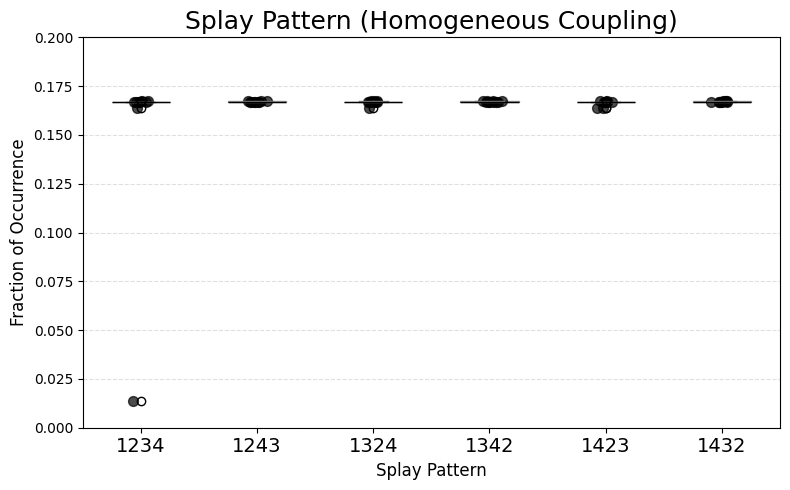

In [55]:

# Collect all unique pattern names across all runs
all_patterns = sorted({p for run in patterns_all_runs_homo for p in run.keys()})

# Build fraction matrix (runs × patterns)
fractions_per_run = []
for run in patterns_all_runs_homo:
    total = sum(len(times) for times in run.values())
    fractions = [len(run.get(p, [])) / total if total > 0 else 0 for p in all_patterns]
    fractions_per_run.append(fractions)
fractions_per_run = np.array(fractions_per_run)  # shape: (num_runs, num_patterns)

# --- Plot ---
plt.figure(figsize=(8, 5))

# Boxplot (each pattern’s distribution across runs)
plt.boxplot(fractions_per_run, labels=all_patterns, patch_artist=True,
            boxprops=dict(facecolor='none', alpha=0.4),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'))

# Overlay individual points for each run (dot jitter)
for i in range(len(all_patterns)):
    x = np.random.normal(i + 1, 0.04, size=fractions_per_run.shape[0])  # small jitter
    plt.scatter(x, fractions_per_run[:, i],
                alpha=0.7, s=50, edgecolors='black', color='black')
plt.ylim(0, 0.2)
plt.ylabel("Fraction of Occurrence", fontsize=12)
plt.xlabel("Splay Pattern", fontsize=12)
plt.title("Splay Pattern (Homogeneous Coupling)", fontsize=18)
plt.xticks(rotation=0, ha='center')
plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


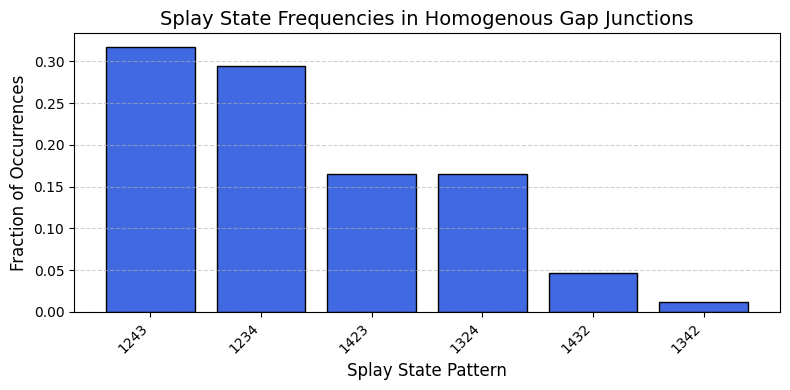

In [45]:

pattern_names = list(patterns_combined.keys())
occurrences = np.array([len(times) for times in patterns_combined.values()])

# Normalize to fractions (sum = 1)
fractions = occurrences / occurrences.sum()

# Sort patterns by descending frequency
sorted_indices = np.argsort(fractions)[::-1]
pattern_names = [pattern_names[i] for i in sorted_indices]
fractions = fractions[sorted_indices]
# Normalize to fractions (sum = 1)
fractions = occurrences / occurrences.sum()
# Sort patterns by descending frequency
sorted_indices = np.argsort(fractions)[::-1]
pattern_names = [pattern_names[i] for i in sorted_indices]
fractions = fractions[sorted_indices]
if g_gap is ggap_hom:
    title = 'Homogeneous Gap Junctions'
else:
    title = 'Heterogeneous Gap Junctions'

plt.figure(figsize=(8, 4))
plt.bar(pattern_names, fractions, color='royalblue', edgecolor='black')
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Fraction of Occurrences', fontsize=12)
plt.title(f'Splay State Frequencies in Homogenous Gap Junctions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [60]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
time_of_sim = 10
num_runs = 10
g_gap = ggap_het

# g_gap = .15*nS
dur = time_of_sim*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 

fname='SNL_weakcoupling_nonoise'

# φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
# initial_values = pick_initial_phase_SNL(φs_chosen)




patterns_all_runs_hetero = []
for iter in range(num_runs):
    initial_values = pick_initial_phase_SNL(φs_chosen)
    patterns_combined = {}
    for i in range(6):  # e.g., num_runs = 10
        # initial_values = random_initial_phase_SNL(5)
        # φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
        
        initial_values = pick_initial_phase_SNL(φs_chosen[i])
        StM1, SpM1 = run_sim(
            N, md_SNL, g_gap, None,
            initial_values=initial_values,
            dur=dur, σnoise=0.5e-9,
            solver=solver, dt=dt
        )

        patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)
        # patterns_combined.append(patterns)
        # Combine with the main dictionary
        for pattern, times in patterns.items():
            if pattern not in patterns_combined:
                patterns_combined[pattern] = list(times)
            else:
                patterns_combined[pattern].extend(times)
    patterns_all_runs_hetero.append(patterns_combined)

Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 6s
Star

WARNING    C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_20232\3272372885.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total = sum(len(times) for times in run.values())
 [py.warnings]
WARNING    C:\Users\aSuryawanshi\AppData\Local\Temp\ipykernel_20232\3272372885.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fractions_per_run, labels=all_patterns, patch_artist=True,
 [py.warnings]


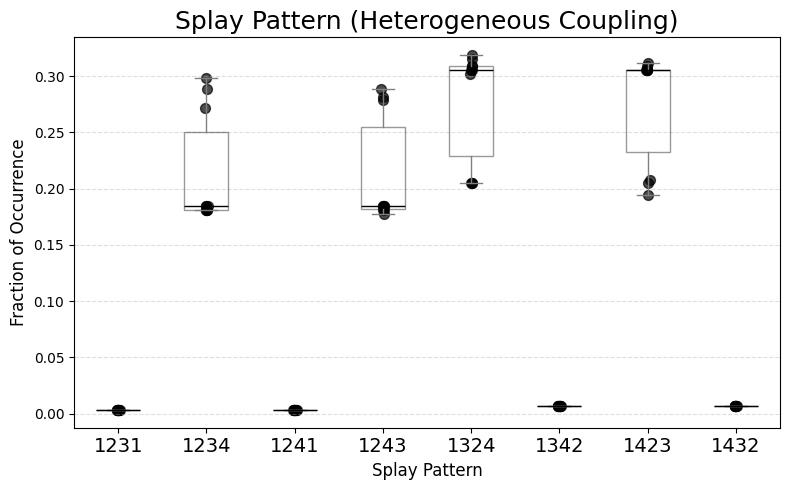

In [61]:

# Collect all unique pattern names across all runs
all_patterns = sorted({p for run in patterns_all_runs_hetero for p in run.keys()})

# Build fraction matrix (runs × patterns)
fractions_per_run = []
for run in patterns_all_runs_hetero:
    total = sum(len(times) for times in run.values())
    fractions = [len(run.get(p, [])) / total if total > 0 else 0 for p in all_patterns]
    fractions_per_run.append(fractions)
fractions_per_run = np.array(fractions_per_run)  # shape: (num_runs, num_patterns)

# --- Plot ---
plt.figure(figsize=(8, 5))

# Boxplot (each pattern’s distribution across runs)
plt.boxplot(fractions_per_run, labels=all_patterns, patch_artist=True,
            boxprops=dict(facecolor='none', alpha=0.4),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'))

# Overlay individual points for each run (dot jitter)
for i in range(len(all_patterns)):
    x = np.random.normal(i + 1, 0.01, size=fractions_per_run.shape[0])  # small jitter
    plt.scatter(x, fractions_per_run[:, i],
                alpha=0.7, s=50, edgecolors='black', color='black')

plt.ylabel("Fraction of Occurrence", fontsize=12)
plt.xlabel("Splay Pattern", fontsize=12)
plt.title("Splay Pattern (Heterogeneous Coupling)", fontsize=18)
plt.xticks(rotation=0, ha='center')
plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [62]:
with open("heterogenous_splay_states_10_10_3.pkl", "wb") as f:
    pickle.dump(patterns_all_runs_hetero, f)
